## Аналитика продаж
Это данные о продажах Amazon c сайта Kaggle.Необходимо предобработать данные и найти ответы на вопросы :

### Ответить на вопросы : 

    1.Какой год был лучшим для продаж? Сколько было заработано в этом году?

    2.Какой месяц был лучшим для продаж? Сколько было заработано в этом месяце?

    3.В каком городе было наибольшее количество продаж?

    4.В какое время мы должны показывать рекламу, чтобы максимизировать вероятность того, что клиент купит продукт?

    5.Какие продукты чаще всего продаются вместе?

    6.Какой товар продается больше всего? Как вы думаете, почему он продается больше всего?

#### Описание данных:
   **Order ID** - идентификатор заказа — Этот номер может быть полезен продавцу, когда он пытается узнать определенные детали заказа, такие как дата отправки или статус.
    
   **Product** - Товар, который был продан.
   
   **Quantity Ordered** — Заказанное количество — это общее количество товара, заказанного в первоначальном заказе 
   
   **Price Each**	 - Цена каждого товара.
   
   **Order Date** — это дата, когда клиент запрашивает отправку заказа.
   
   **Purchase Address** -  Адрес доставки

#### Откроем файл и предобработаем данные 

In [261]:
import pandas as pd
import os
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from itertools import combinations
from collections import Counter

warnings.filterwarnings('ignore')

есть 12 файлов записанных за год, каждый соответствует месяцу года.

прочитаем все данные из папки и запишем их в общий csv файл

In [136]:
file = [file for file in os.listdir('/Users/v.obrosova/Documents/csv датасеты/archive')]

all_months = pd.DataFrame()

for file in file:
    df = pd.read_csv("/Users/v.obrosova/Documents/csv датасеты/archive/" + file)
    all_months = pd.concat([all_months, df])
    
all_months.head()

all_months.to_csv('all_months.csv' ,index = False)

читаем заново из обьединенного файла

In [4]:
all_data = pd.read_csv('/Users/v.obrosova/Documents/Kaggle/all_months.csv')
all_data.head()

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
0,295665,Macbook Pro Laptop,1,1700,12/30/19 00:01,"136 Church St, New York City, NY 10001"
1,295666,LG Washing Machine,1,600.0,12/29/19 07:03,"562 2nd St, New York City, NY 10001"
2,295667,USB-C Charging Cable,1,11.95,12/12/19 18:21,"277 Main St, New York City, NY 10001"
3,295668,27in FHD Monitor,1,149.99,12/22/19 15:13,"410 6th St, San Francisco, CA 94016"
4,295669,USB-C Charging Cable,1,11.95,12/18/19 12:38,"43 Hill St, Atlanta, GA 30301"


In [5]:
all_data.shape

(186850, 6)

In [6]:
all_data.isna().sum()

Order ID            545
Product             545
Quantity Ordered    545
Price Each          545
Order Date          545
Purchase Address    545
dtype: int64

In [7]:
all_data.dropna(inplace=True)
all_data.shape

(186305, 6)

In [8]:
all_data = all_data.rename(columns = (lambda x: x.replace(' ','_')))
all_data.head()

,Order_ID,Product,Quantity_Ordered,Price_Each,Order_Date,Purchase_Address
0,295665,Macbook Pro Laptop,1,1700,12/30/19 00:01,"136 Church St, New York City, NY 10001"
1,295666,LG Washing Machine,1,600.0,12/29/19 07:03,"562 2nd St, New York City, NY 10001"
2,295667,USB-C Charging Cable,1,11.95,12/12/19 18:21,"277 Main St, New York City, NY 10001"
3,295668,27in FHD Monitor,1,149.99,12/22/19 15:13,"410 6th St, San Francisco, CA 94016"
4,295669,USB-C Charging Cable,1,11.95,12/18/19 12:38,"43 Hill St, Atlanta, GA 30301"


Добавим колонку с датой для удобства дальнейшей работы

при смене типа колонки 'Order_Date' получили ошибку что на позиции 254 есть значение не соответствующее параметрам даты. Найдем и исключим ошибку


In [9]:
np.array(all_data.Order_Date)[254]

'Order Date'

In [10]:
all_data = all_data[all_data['Order_Date'].str[0:2]!= 'Or']

Конвертируем остальные колонки 

In [11]:
all_data['Order_Date'] = pd.to_datetime(all_data['Order_Date'])
all_data['Quantity_Ordered'] = all_data['Quantity_Ordered'].astype(int)
all_data['Price_Each'] = all_data['Price_Each'].astype(float)

all_data.dtypes

Order_ID                    object
Product                     object
Quantity_Ordered             int64
Price_Each                 float64
Order_Date          datetime64[ns]
Purchase_Address            object
dtype: object

по итогу предобработки сделано:

    -обьединение разных csv файлов в 1 датасет
    -удалено 545 пустях значений, число строк после удаления 185950, 8 колонок
    -найдена ошибка в данных которая мешала конвертировать столбец в нужный тип данных,исключили ее из данных
    -изменен тип данных для других необходимых колонок



###  1.Какой год был лучшим для продаж? Сколько было заработано в этом году?

Добавим колонку продаж(sales ), года(year) и месяца (month) для каждого заказа для удобства работы далее

In [12]:
all_data['Sales'] = all_data['Quantity_Ordered'] * all_data['Price_Each']
all_data['Month'] = all_data['Order_Date'].dt.month
all_data['Year'] = all_data['Order_Date'].dt.year
all_data.head()

,Order_ID,Product,Quantity_Ordered,Price_Each,Order_Date,Purchase_Address,Sales,Month,Year
0,295665,Macbook Pro Laptop,1,1700.00,2019-12-30 00:01:00,"136 Church St, New York City, NY 10001",1700.00,12,2019
1,295666,LG Washing Machine,1,600.00,2019-12-29 07:03:00,"562 2nd St, New York City, NY 10001",600.00,12,2019
2,295667,USB-C Charging Cable,1,11.95,2019-12-12 18:21:00,"277 Main St, New York City, NY 10001",11.95,12,2019
3,295668,27in FHD Monitor,1,149.99,2019-12-22 15:13:00,"410 6th St, San Francisco, CA 94016",149.99,12,2019
4,295669,USB-C Charging Cable,1,11.95,2019-12-18 12:38:00,"43 Hill St, Atlanta, GA 30301",11.95,12,2019


In [49]:
Years_sales = all_data.groupby('Year')\
                      .sum()\
                      .astype(int)
Years_sales

,Quantity_Ordered,Price_Each,Sales,Month
Year,,,,
2019,209038,34280627,34483365,1312613
2020,41,8503,8670,34


In [43]:
all_data[['Year','Month']].value_counts()

Year  Month
2019  12       24984
      10       20282
      4        18279
      11       17573
      5        16566
      3        15153
      7        14293
      6        13554
      2        11975
      8        11961
      9        11621
      1         9675
2020  1           34
dtype: int64

по сумме продаж больша сумма в 2019г потому что большая часть всех данных в документе записана именно в этот год, на 2020 приходиться лишь 34 значения, следовательно мы не можем полноценно оценить разницу продаж этих лет

In [47]:
all_money = all_data.Price_Each.sum().astype(int)
all_money

34289130

In [46]:
Years_sales['share_of_sales'] = round((Years_sales['Price_Each'] / Years_sales.Price_Each.sum())*100,2)
Years_sales

,Quantity_Ordered,Price_Each,Sales,Month,share_of_sales
Year,,,,,
2019,209038,34280627,34483365,1312613,99.98
2020,41,8503,8670,34,0.02


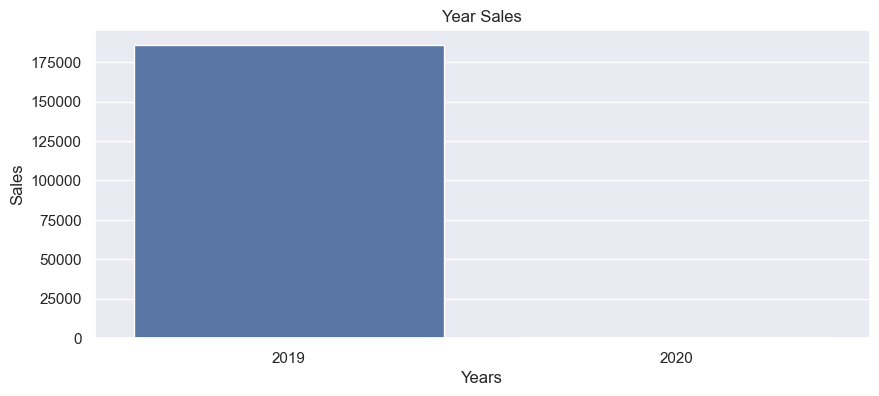

In [207]:
plt.figure(figsize=(10,4))
sns.countplot(x = 'Year', data = all_data)

plt.title('Year Sales')
plt.xlabel('Years')
plt.ylabel('Sales')
sns.set()

### По результатам 1 задания удалось узнать:
        - Общая сумма заработанных денег за все года = 34 289 130 usd
        - 99.98% продаж пришлось на 2019г, 0.02% на 2020г
        - больше всего денег заработано в 2019г = 34 280 627 usd
    
Исходя из данных что у нас есть лучший год по сумме продаж 2019, но так как у нас еще нет полной иноформации о продажах в 2020 в другие месяца то будет неверно называть 2019 лучшим годом
    

### 2.Какой месяц был лучшим для продаж? Сколько было заработано в этом месяце?

In [60]:
results = all_data.groupby('Month')\
                  .sum()
results

,Quantity_Ordered,Price_Each,Sales,Year
Month,,,,
1,10903,1811768.38,1822256.73,19602505
2,13449,2188884.72,2202022.42,24177525
3,17005,2791207.83,2807100.38,30593907
4,20558,3367671.02,3390670.24,36905301
5,18667,3135125.13,3152606.75,33446754
6,15253,2562025.61,2577802.26,27365526
7,16072,2632539.56,2647775.76,28857567
8,13448,2230345.42,2244467.88,24149259
9,13109,2084992.09,2097560.13,23462799


In [61]:
results['Price_Each'].idxmax()

12

In [63]:
results['Price_Each'].max().round()

4588415.0

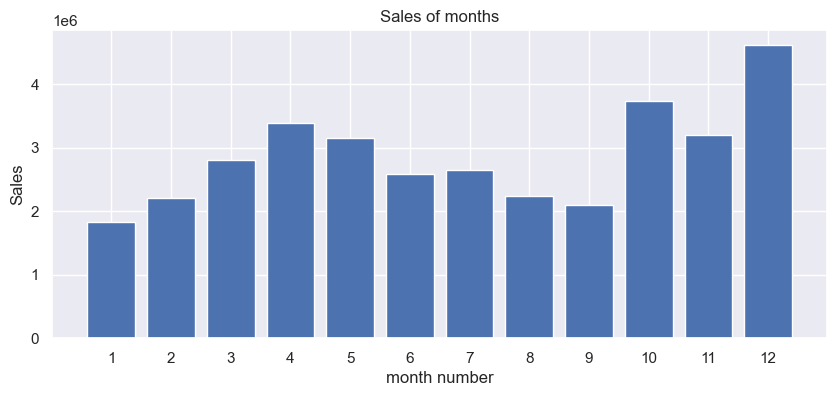

In [384]:
plt.figure(figsize=(10,4))
months = range(1,13)
plt.bar(months,results['Sales'])
plt.xticks(months)

plt.title('Sales of months')
plt.xlabel('month number')
plt.ylabel('Sales')

sns.set()

Лучшим месяцем для продаж был Декабрь, в этом месяце заработано = 4 588 415 usd

Возможными на продажи повлиял праздник или активные рекламные компании в этот период, необходимо больше данных для проверки второго утверждения

###  3.В каком городе было наибольшее количество продаж?

Добавим новую колонку для деления всех строк по городам

In [126]:
def get_city(x):
    return x.split(',')[1]

def get_index(x):
    return x.split(',')[2].split(' ')[1]

all_data['City'] = all_data['Purchase_Address'].apply(lambda x: f" {get_city(x)}({get_index(x)})")

In [127]:
all_data.head()

,Order_ID,Product,Quantity_Ordered,Price_Each,Order_Date,Purchase_Address,Sales,Month,Year,City
0,295665,Macbook Pro Laptop,1,1700.00,2019-12-30 00:01:00,"136 Church St, New York City, NY 10001",1700.00,12,2019,New York City(NY)
1,295666,LG Washing Machine,1,600.00,2019-12-29 07:03:00,"562 2nd St, New York City, NY 10001",600.00,12,2019,New York City(NY)
2,295667,USB-C Charging Cable,1,11.95,2019-12-12 18:21:00,"277 Main St, New York City, NY 10001",11.95,12,2019,New York City(NY)
3,295668,27in FHD Monitor,1,149.99,2019-12-22 15:13:00,"410 6th St, San Francisco, CA 94016",149.99,12,2019,San Francisco(CA)
4,295669,USB-C Charging Cable,1,11.95,2019-12-18 12:38:00,"43 Hill St, Atlanta, GA 30301",11.95,12,2019,Atlanta(GA)


In [173]:
city_sales = all_data.groupby('City')\
                     .agg({'Sales':'sum'})                        
city_sales

,Sales
City,
Atlanta(GA),2795498.58
Austin(TX),1819581.75
Boston(MA),3661642.01
Dallas(TX),2767975.40
Los Angeles(CA),5452570.80
New York City(NY),4664317.43
Portland(ME),449758.27
Portland(OR),1870732.34
San Francisco(CA),8262203.91


In [174]:
city_sales.Sales.max()

8262203.91

In [176]:
city_sales.Sales.idxmax()

'  San Francisco(CA)'

In [178]:
visual_cities = city_sales.reset_index()

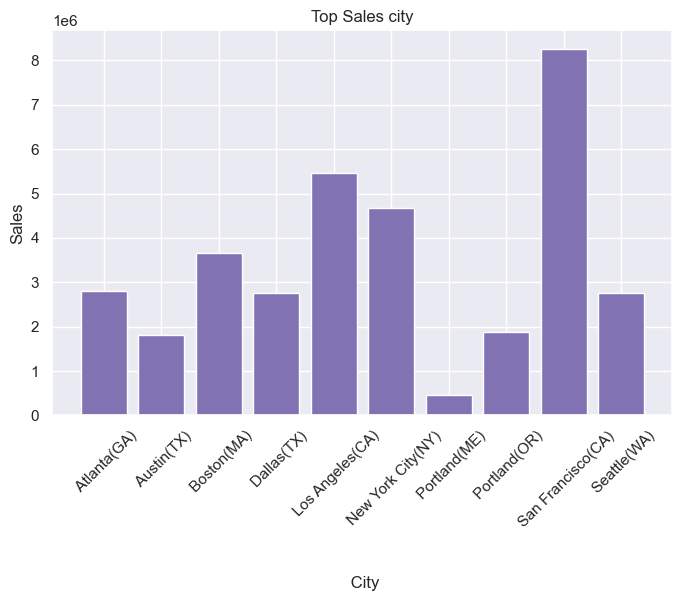

In [379]:
plt.figure(figsize = (8,5))
plt.bar(visual_cities['City'], visual_cities['Sales'], color = 'm')

plt.title('Top Sales city')
plt.xticks(rotation = 45)
plt.xlabel('\n \n City')
plt.ylabel('Sales')


sns.set()

посмотри на долю продаж San Francisco, в каждом месяце относительно суммы продаж всех городов

In [247]:
visual_cities['percents_of_all_Sales'] = round((visual_cities['Sales']/(visual_cities['Sales'].sum())) * 100,2)
visual_cities

,City,Sales,percents_of_all_Sales
0,Atlanta(GA),2795498.58,8.10
1,Austin(TX),1819581.75,5.28
2,Boston(MA),3661642.01,10.62
3,Dallas(TX),2767975.40,8.02
4,Los Angeles(CA),5452570.80,15.81
5,New York City(NY),4664317.43,13.52
6,Portland(ME),449758.27,1.30
7,Portland(OR),1870732.34,5.42
8,San Francisco(CA),8262203.91,23.95
9,Seattle(WA),2747755.48,7.97


In [249]:
visual_cities.percents_of_all_Sales.mean().round()

10.0

In [232]:
sanf = all_data.query('City == "  San Francisco(CA)"').groupby('Month').agg({'Sales':'sum'})
others = all_data.query('City != "  San Francisco(CA)"').groupby('Month').sum()

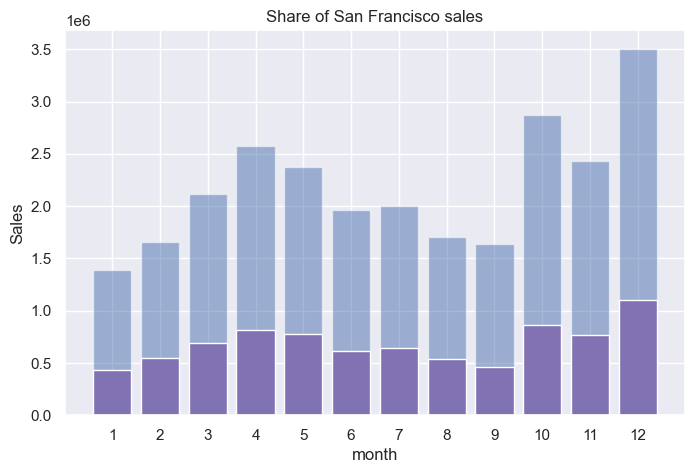

In [385]:
plt.figure(figsize = (8,5))
plt.bar(months,others['Sales'], color = 'b', alpha = 0.5)
plt.bar(months, sanf['Sales'], color = 'm')
plt.legend

plt.xticks(months)
plt.title('Share of San Francisco sales')
plt.xlabel('month')
plt.ylabel('Sales')

sns.set()

Наибольшее количесвто продаж было в San Francisco, сумма продаж за все время = 8 262 204 usd

Также на графике видно что в течении всего года, каждый месяц доля продаж San Francisco больше чем у остальных городов, процент = 23.95% , это на 14% выше чем в среднем по всем месяцам.

### 4.В какое время мы должны показывать рекламу, чтобы максимизировать вероятность того, что клиент купит продукт?

создадим колонки времени для визуализации распределения времени по часам

In [251]:
all_data['Hour'] = all_data['Order_Date'].dt.hour
all_data['minute'] = all_data['Order_Date'].dt.minute
all_data['count'] = 1

all_data.head()

,Order_ID,Product,Quantity_Ordered,Price_Each,Order_Date,Purchase_Address,Sales,Month,Year,City,Hour,minute,count
0,295665,Macbook Pro Laptop,1,1700.00,2019-12-30 00:01:00,"136 Church St, New York City, NY 10001",1700.00,12,2019,New York City(NY),0,1,1
1,295666,LG Washing Machine,1,600.00,2019-12-29 07:03:00,"562 2nd St, New York City, NY 10001",600.00,12,2019,New York City(NY),7,3,1
2,295667,USB-C Charging Cable,1,11.95,2019-12-12 18:21:00,"277 Main St, New York City, NY 10001",11.95,12,2019,New York City(NY),18,21,1
3,295668,27in FHD Monitor,1,149.99,2019-12-22 15:13:00,"410 6th St, San Francisco, CA 94016",149.99,12,2019,San Francisco(CA),15,13,1
4,295669,USB-C Charging Cable,1,11.95,2019-12-18 12:38:00,"43 Hill St, Atlanta, GA 30301",11.95,12,2019,Atlanta(GA),12,38,1


In [254]:
hour_count = all_data.groupby('Hour').count()
hour_count.head()

,Order_ID,Product,Quantity_Ordered,Price_Each,Order_Date,Purchase_Address,Sales,Month,Year,City,minute,count
Hour,,,,,,,,,,,,
0,3910,3910,3910,3910,3910,3910,3910,3910,3910,3910,3910,3910
1,2350,2350,2350,2350,2350,2350,2350,2350,2350,2350,2350,2350
2,1243,1243,1243,1243,1243,1243,1243,1243,1243,1243,1243,1243
3,831,831,831,831,831,831,831,831,831,831,831,831
4,854,854,854,854,854,854,854,854,854,854,854,854


(0.0, 23.0)

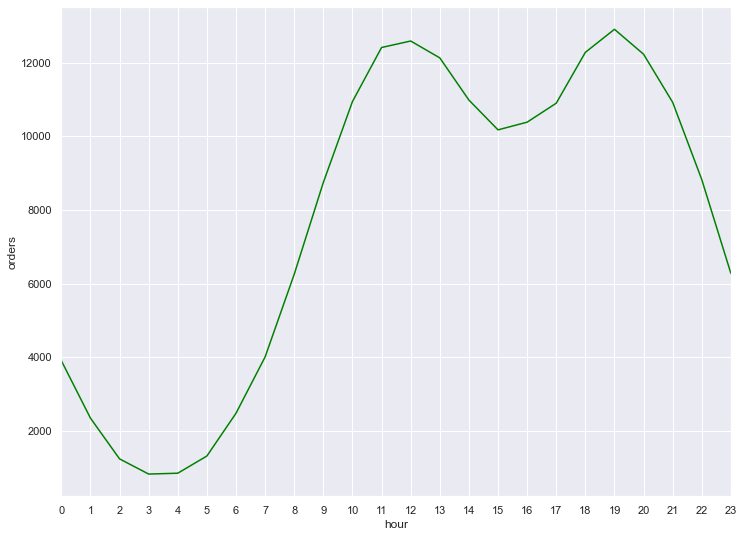

In [155]:
hours = [hour for hour, df in all_data.groupby('Hour')]

plt.plot(hours, hour_count.Quantity_Ordered, color = 'Green')
plt.xticks(hours)

plt.xlabel('hour')
plt.ylabel('orders')
plt.xlim(0,23)


распределения количества продаж имеет 2 пика которые начинают максимальный рост с 9-10ч утра и 16-17ч вечера

Лучшее время для размещение рекламы 9-10 утра, потому что в это время увеличевается количество заказов.

###  5.Какие продукты чаще всего продаются вместе?



Cоздадим список покупок для каждого покупателя за все время

In [264]:
df = all_data[all_data['Order_ID'].duplicated(keep = False)]

In [265]:
df['grouped'] = df.groupby('Order_ID')['Product'].transform(lambda x: ','.join(x))
df.head()

,Order_ID,Product,Quantity_Ordered,Price_Each,Order_Date,Purchase_Address,Sales,Month,Year,City,Hour,minute,count,grouped
16,295681,Google Phone,1,600.00,2019-12-25 12:37:00,"79 Elm St, Boston, MA 02215",600.00,12,2019,Boston(MA),12,37,1,"Google Phone,USB-C Charging Cable,Bose SoundSp..."
17,295681,USB-C Charging Cable,1,11.95,2019-12-25 12:37:00,"79 Elm St, Boston, MA 02215",11.95,12,2019,Boston(MA),12,37,1,"Google Phone,USB-C Charging Cable,Bose SoundSp..."
18,295681,Bose SoundSport Headphones,1,99.99,2019-12-25 12:37:00,"79 Elm St, Boston, MA 02215",99.99,12,2019,Boston(MA),12,37,1,"Google Phone,USB-C Charging Cable,Bose SoundSp..."
19,295681,Wired Headphones,1,11.99,2019-12-25 12:37:00,"79 Elm St, Boston, MA 02215",11.99,12,2019,Boston(MA),12,37,1,"Google Phone,USB-C Charging Cable,Bose SoundSp..."
36,295698,Vareebadd Phone,1,400.00,2019-12-13 14:32:00,"175 1st St, New York City, NY 10001",400.00,12,2019,New York City(NY),14,32,1,"Vareebadd Phone,USB-C Charging Cable"


In [266]:
df = df[['Order_ID', 'grouped']].drop_duplicates()
df.head()

,Order_ID,grouped
16,295681,"Google Phone,USB-C Charging Cable,Bose SoundSp..."
36,295698,"Vareebadd Phone,USB-C Charging Cable"
42,295703,"AA Batteries (4-pack),Bose SoundSport Headphones"
66,295726,"iPhone,Lightning Charging Cable"
76,295735,"iPhone,Apple Airpods Headphones,Wired Headphones"


In [267]:
count = Counter()

for row in df['grouped']:
    row_list = row.split(',')
    count.update(Counter(combinations(row_list, 2)))

In [268]:
for key, value in count.most_common(10):
    print(key, value)

('iPhone', 'Lightning Charging Cable') 1005
('Google Phone', 'USB-C Charging Cable') 987
('iPhone', 'Wired Headphones') 447
('Google Phone', 'Wired Headphones') 414
('Vareebadd Phone', 'USB-C Charging Cable') 361
('iPhone', 'Apple Airpods Headphones') 360
('Google Phone', 'Bose SoundSport Headphones') 220
('USB-C Charging Cable', 'Wired Headphones') 160
('Vareebadd Phone', 'Wired Headphones') 143
('Lightning Charging Cable', 'Wired Headphones') 92


больше всего комбинации у ('iPhone', 'Lightning Charging Cable'), эти товары чаще оказываются в одной корзине 
скорее всего потому что компания apple в 2020 году начала продавать телефоны без зарядки в комплекте и покуптели сразу берут полный набор

###  6.Какой товар продается больше всего? Как вы думаете, почему он продается больше всего?

сгруппируем все продукты и посчитаем их проданное количество и частоту попадания в заказ

найдем продукт с самым большим проданным количеством 

In [352]:
top_quantity_product =all_data.groupby('Product')\
                              .agg({'Quantity_Ordered':'sum'})\
                              .sort_values('Quantity_Ordered', ascending = False)
top_quantity_product.idxmax()

Quantity_Ordered    AAA Batteries (4-pack)
dtype: object

In [353]:
top_quantity_product.max()

Quantity_Ordered    31017
dtype: int64

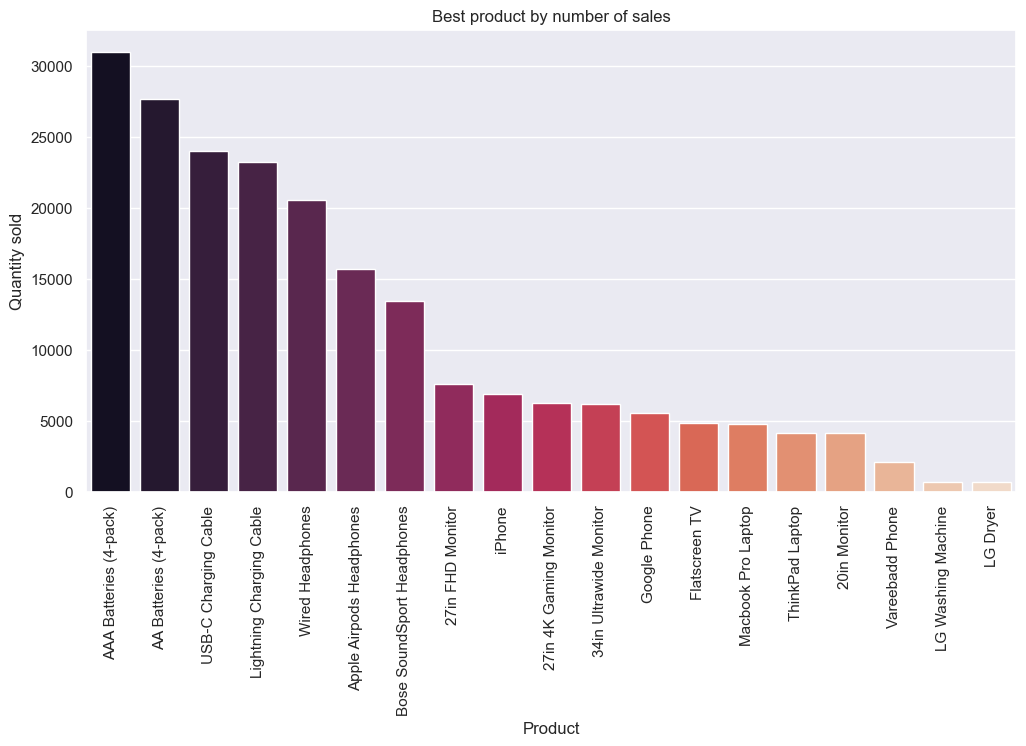

In [393]:
visualization = top_quantity_product.reset_index()
sns.barplot(data = visualization, x = 'Product', y = 'Quantity_Ordered', palette = 'rocket')

plt.xticks(rotation = 90)
plt.ylabel('Quantity sold')
plt.title('Best product by number of sales')

sns.set()

посчитаем частоты попадания категории товара в заказ

In [336]:
all_data.Product.value_counts().to_frame().T

,USB-C Charging Cable,Lightning Charging Cable,AAA Batteries (4-pack),AA Batteries (4-pack),Wired Headphones,Apple Airpods Headphones,Bose SoundSport Headphones,27in FHD Monitor,iPhone,27in 4K Gaming Monitor,34in Ultrawide Monitor,Google Phone,Flatscreen TV,Macbook Pro Laptop,ThinkPad Laptop,20in Monitor,Vareebadd Phone,LG Washing Machine,LG Dryer
Product,21903,21658,20641,20577,18882,15549,13325,7507,6842,6230,6181,5525,4800,4724,4128,4101,2065,666,646


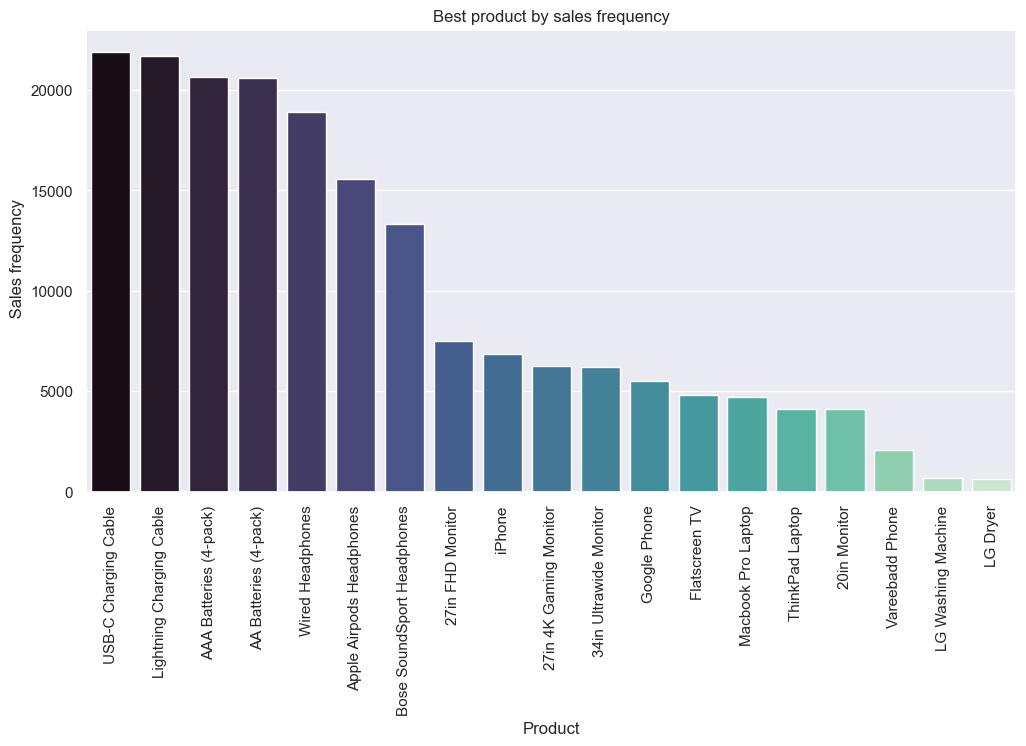

In [402]:
top_frequency_product = all_data.groupby('Product', as_index = False)\
                              .agg({'Quantity_Ordered':'count'})\
                              .sort_values('Quantity_Ordered', ascending = False)

top_frequency_product = top_frequency_product.reset_index()
sns.barplot(data = top_frequency_product, x = 'Product', y = 'Quantity_Ordered', palette = 'mako')

plt.xticks(rotation = 90)
plt.ylabel(' Sales frequency')
plt.title('Best product by sales frequency')

sns.set()

Думаю что на вопрос "Какой товар продается больше всего?" может быть как товар который чаще попадает в заказ, так и товар которого больше по количеству в заказе.

Таких товаров оказалось несколько: 
   - Чаще всего покупают USB-C Charging Cable
       - А больше по количеству продано товара AAA Batteries (4-pack)

Вероятно зарядные кабели (USB-C Charging Cable) покупают чаще потому что на фоне всего ассортимента товаров у них меньше всего срок службы поэтому их чаще остальных товаров заменяют на новые. А именно этот тип кабеля выбирают потому что он универсален и подходит к разным типам устройств , не только к телефону как например у iphone, чьи кабели не так универсальны и заняли 2-е место по частоте заказа.

А Батарейки(AAA Batteries (4-pack)) покупают больше потому что это ААА самый стандартный тип батареек который чаще встречается например в домашней электроаппаратуре или приборах для туризма. Наша жизнь наполнена большим количеством такой техники.

#### Итоги работы:
       
    Самое большое число данных о продажах за 2019 год поэтому сумма продаж больше именно в этом году, данные за 2020 год еще не полные для сравнения, ,удалось заработать за 2019 г = 34 483 365 usd
    Лучшим месяцем оказался Декабрь с суммой продаж = 4 588 415 usd, вероятно из-за активных продаж перед праздником
    Больше всего продаж было в San Francisco, этот штат занимает самую большую долю продаж во все месяца,его средняя сумма продаж на 14% выше среднего по всем штатам
    Касательно продуктов больше всего покупают 2 товара :
           -чаще выбирают - USB-C Charging Cable, 
           -большее количество покупают AAA Batteries (4-pack), на фоне других продуктов эти товары имеют меньший срок эксплуатации и больше распространены в быту.
    Товары которые чаще попадают в один заказ это 'iPhone' и 'Lightning Charging Cable', потому что у iphone нет зарядного кабеля в комплекте и он допокупается отдельно.
    Чтобы максимизировать продажи рекомендуется выкладывать рекламу с 9-10утра, вечернее время с 16-17ч также максимизирует продажи.
       
       
       
      